In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import os
from torch.utils.data import ConcatDataset

In [3]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [4]:
import numpy as np
import seaborn as sns

In order to set-up the dataset I had to download if folllowing an online procedure. 
The dataset was dismissed by torchivision and is not more available.

The directory structure should be:

└── stanford_cars 
    └── cars_test_annos_withlabels.mat 
    └── cars_train
        └── *.jpg
    └── cars_test
        └── .*jpg
    └── devkit
        ├── cars_meta.mat
        ├── cars_test_annos.mat
        ├── cars_train_annos.mat
        ├── eval_train.m
        ├── README.txt
        └── train_perfect_preds.txt

In [5]:
# Load the dataset
dataset = torchvision.datasets.StanfordCars(root="./")

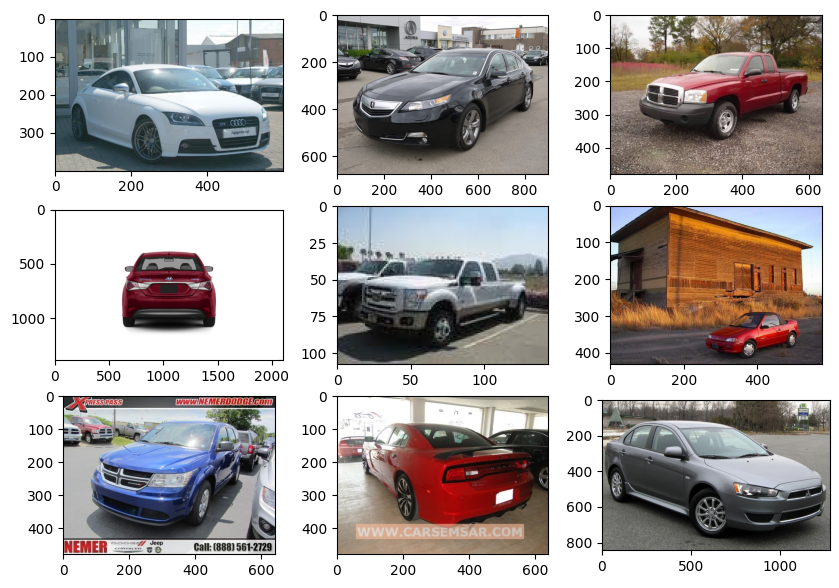

In [6]:
# Display some random images of the dataset
fig, ax = plt.subplots(3, 3, figsize=(10, 7))
for i in range(3):
    for j in range(3):
        ax[i, j].imshow(dataset[i * 3 + j][0])
        ax[i, j].axis("on")
plt.show()

changes this part 

In [7]:
from torchvision import transforms
from torchvision.transforms import AutoAugment, AutoAugmentPolicy
from torch.utils.data import ConcatDataset, DataLoader
from torchvision import datasets

# Define enhanced transformations for the training set
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),  # Increased rotation range
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.15),  # Slightly increased jitter
    transforms.RandomGrayscale(p=0.1),  # Randomly convert images to grayscale with probability 0.1
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),  # Add Gaussian Blur
    AutoAugment(policy=AutoAugmentPolicy.IMAGENET),  # Use AutoAugment policy
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transformations for validation set remain the same
transform_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the datasets
train_dataset = datasets.StanfordCars(root="./", split='train', transform=transform_train)
val_dataset = datasets.StanfordCars(root="./", split='test', transform=transform_val)

# Original dataset without augmentations
transform_original = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Original training dataset
train_dataset_original = datasets.StanfordCars(root="./", split='train', transform=transform_original)

# Combined dataset with both original and augmented images
combined_train_dataset = ConcatDataset([train_dataset, train_dataset_original])

# Create data loaders with increased number of workers and slightly larger batch size if possible
train_loader = DataLoader(combined_train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)


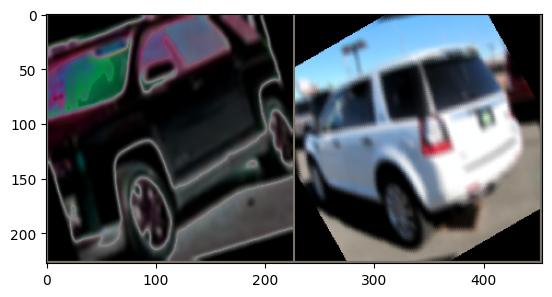

In [8]:
# Display some augmented images from the training set
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

def show_augmented_images(dataloader):
    inputs, classes = next(iter(dataloader))
    out = torchvision.utils.make_grid(inputs)
    imshow(out)

# Create a DataLoader for visualization with a small batch size
vis_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

# Display some augmented images
show_augmented_images(vis_loader)

In [9]:
# Load pretrained EfficientNet model (e.g., efficientnet_b0)
model = models.efficientnet_b0(pretrained=True)

# Modify the final layer to match the number of classes in the Stanford Cars dataset
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 196)  # Stanford Cars dataset has 196 classes

# Determine the appropriate device
if torch.backends.mps.is_available():  # Check for Apple Silicon (M1, M2)
    device = torch.device("mps")
elif torch.cuda.is_available():  # Check for GPU
    device = torch.device("cuda:0")
else:  # Default to CPU
    device = torch.device("cpu")

# Move the model to the appropriate device
model = model.to(device)

print(f"Using device: {device}")

/Users/carpanini24/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/carpanini24/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /Users/carpanini24/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 50.8MB/s]


Using device: mps


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Define Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = nn.functional.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [11]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# Define the Focal Loss (you can adjust alpha and gamma as needed)
criterion = FocalLoss(alpha=1, gamma=2, reduction='mean')

# Change optimizer to Adam with a lower learning rate
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Adjust learning rate scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)


In [12]:
# Function to create a new run directory
def create_new_run_dir(base_log_dir):
    run_number = 0
    while os.path.exists(os.path.join(base_log_dir, f"{run_number:04d}")):
        run_number += 1
    new_run_dir = os.path.join(base_log_dir, f"{run_number:04d}")
    os.makedirs(new_run_dir)
    return new_run_dir

# Base log directory
base_log_dir = "./runs/StanfordCars/"

# Create a new run directory
log_dir = create_new_run_dir(base_log_dir)
writer = SummaryWriter(log_dir)

In [13]:
num_epochs = 50

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    # Training phase
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(combined_train_dataset)
    epoch_acc = running_corrects.float() / len(combined_train_dataset)

    writer.add_scalar('Loss/train', epoch_loss, epoch)
    writer.add_scalar('Accuracy/train', epoch_acc, epoch)
    
    print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_corrects = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

    val_loss /= len(val_dataset)
    val_acc = val_corrects.float() / len(val_dataset)

    writer.add_scalar('Loss/val', val_loss, epoch)
    writer.add_scalar('Accuracy/val', val_acc, epoch)
    
    print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    # Step the scheduler
    scheduler.step()

# Close the TensorBoard writer
writer.close()

Epoch 1/50
Train Loss: 5.0158 Acc: 0.0349
Val Loss: 4.1055 Acc: 0.1846
Epoch 2/50
Train Loss: 3.8287 Acc: 0.2065
Val Loss: 2.4209 Acc: 0.4337
Epoch 3/50
Train Loss: 2.6011 Acc: 0.4089
Val Loss: 1.3949 Acc: 0.6166
Epoch 4/50
Train Loss: 1.8665 Acc: 0.5336
Val Loss: 0.9385 Acc: 0.7029
Epoch 5/50
Train Loss: 1.4194 Acc: 0.6167
Val Loss: 0.7204 Acc: 0.7493
Epoch 6/50
Train Loss: 1.2200 Acc: 0.6677
Val Loss: 0.6775 Acc: 0.7630
Epoch 7/50
Train Loss: 1.1865 Acc: 0.6781
Val Loss: 0.6569 Acc: 0.7669
Epoch 8/50
Train Loss: 1.1467 Acc: 0.6832
Val Loss: 0.6450 Acc: 0.7686
Epoch 9/50
Train Loss: 1.1185 Acc: 0.6901
Val Loss: 0.6285 Acc: 0.7744
Epoch 10/50
Train Loss: 1.0922 Acc: 0.6958
Val Loss: 0.6068 Acc: 0.7781
Epoch 11/50
Train Loss: 1.0841 Acc: 0.7008
Val Loss: 0.6229 Acc: 0.7753
Epoch 12/50
Train Loss: 1.0783 Acc: 0.6976
Val Loss: 0.6078 Acc: 0.7773
Epoch 13/50
Train Loss: 1.0711 Acc: 0.7005
Val Loss: 0.6140 Acc: 0.7785
Epoch 14/50


In [ ]:
torch.save(model.state_dict(), 'trained_model15.pth')

In [ ]:
# Ensure the model is in evaluation mode
model.eval()

# Lists to store true labels and predictions
all_preds = []
all_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        # Store predictions and true labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

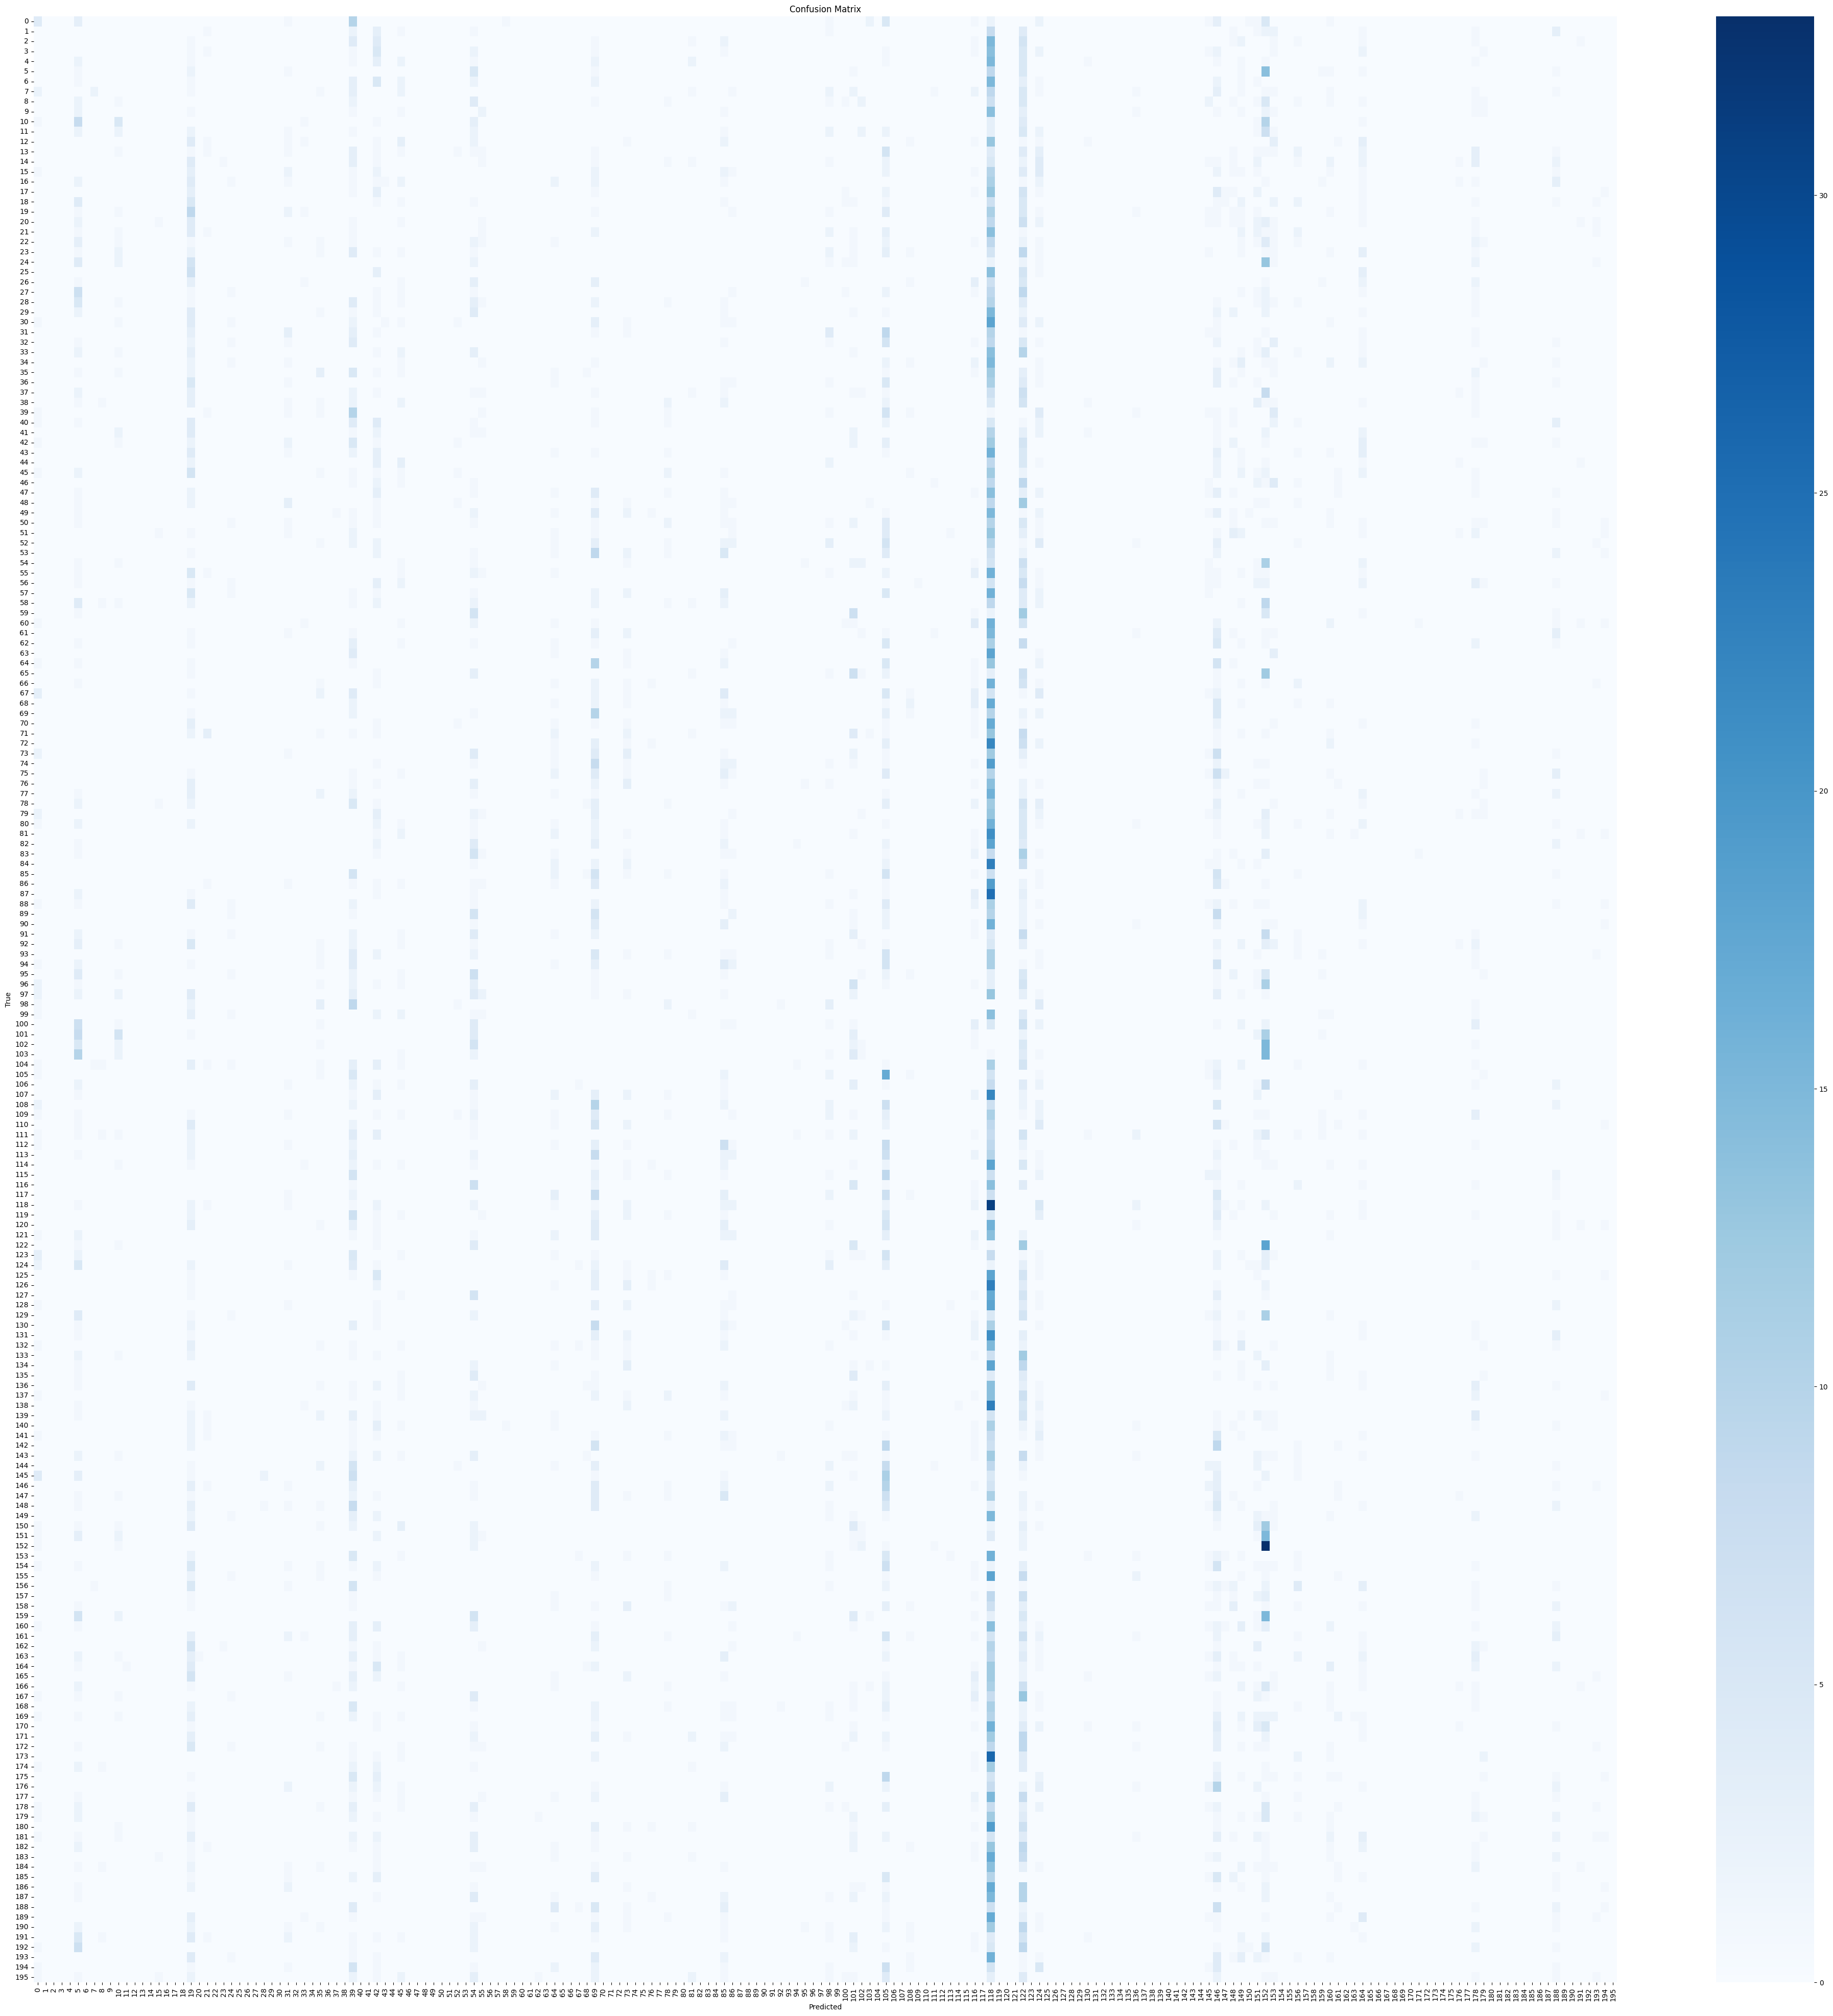

In [ ]:
# Plot the confusion matrix
plt.figure(figsize=(50, 50))
sns.heatmap(cm, annot=False, fmt="d", cmap="Blues", xticklabels=range(196), yticklabels=range(196))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Ensure the model is in evaluation mode
model.eval()

# Function to show an image
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

# Get a batch of validation data
inputs, labels = next(iter(val_loader))
inputs, labels = inputs.to(device), labels.to(device)

# Forward pass to get predictions
outputs = model(inputs)
_, preds = torch.max(outputs, 1)

# Define a list of class names if available
class_names = [str(i) for i in range(196)]  # Modify this with actual class names if available

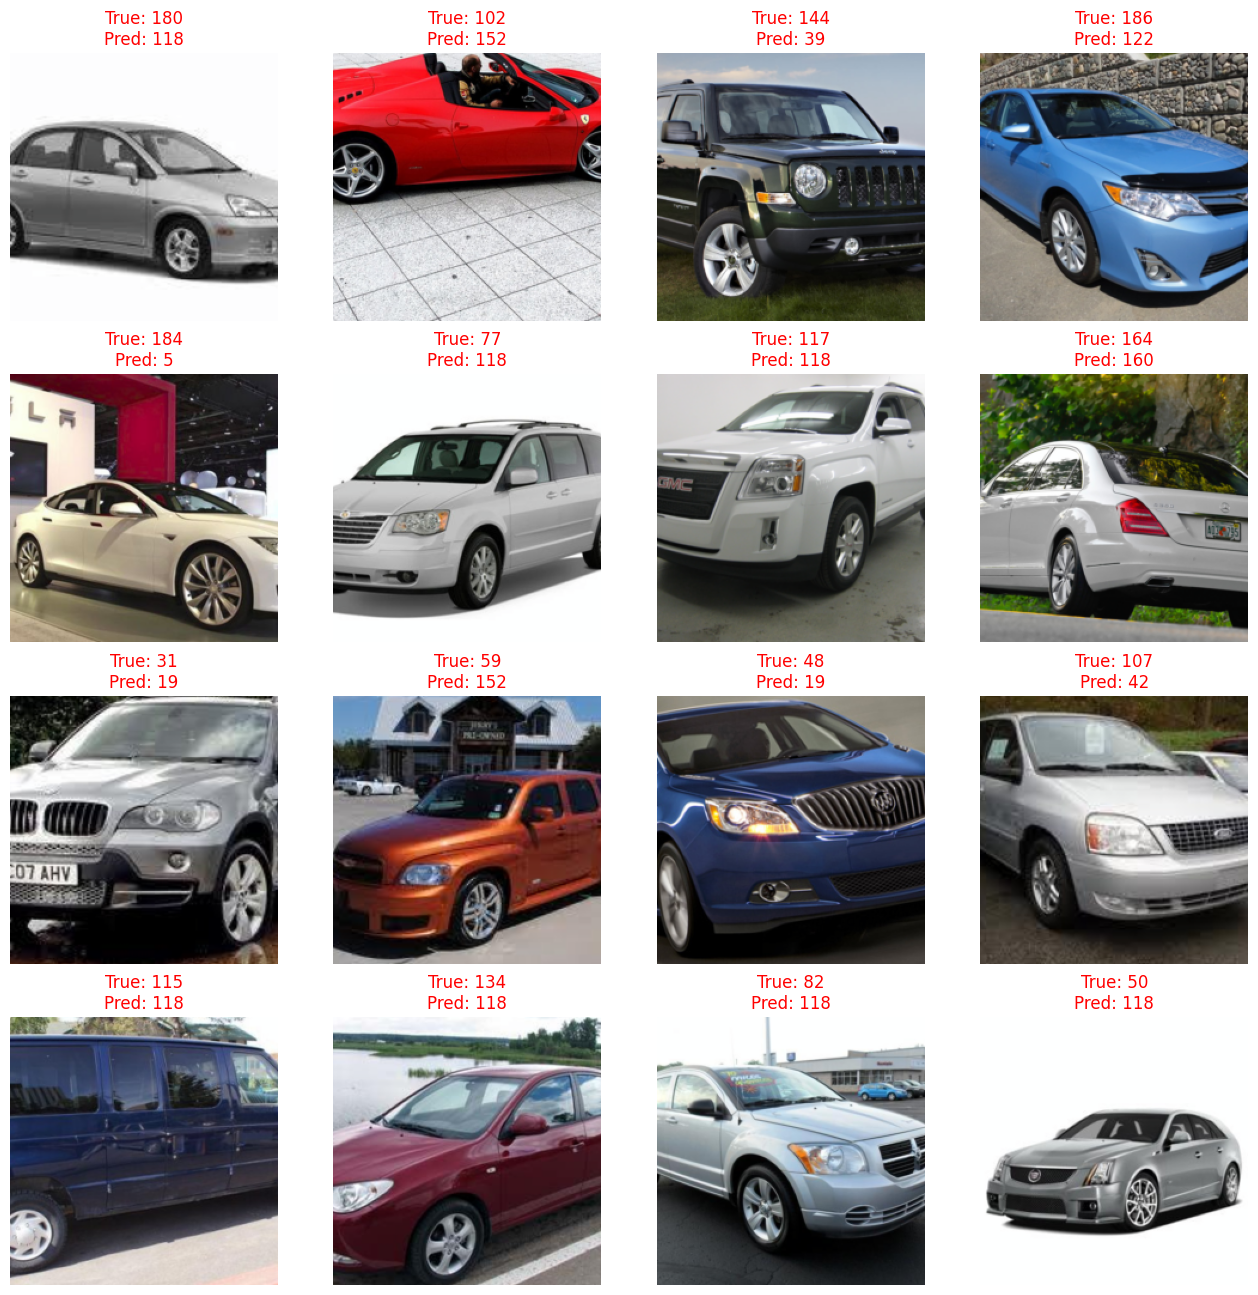

In [ ]:
# Display images with predictions and true labels
plt.figure(figsize=(16, 16))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    imshow(inputs.cpu().data[i])
    true_label = class_names[labels[i].item()] if class_names else labels[i].item()
    pred_label = class_names[preds[i].item()] if class_names else preds[i].item()
    ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=("green" if true_label == pred_label else "red"))
    ax.axis('off')

plt.show()